In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_surface_area_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 90, 71)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:71,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((71,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:
size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]

Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_23128/594757902.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.6
1     492     0:12.4
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.7845166289723D+02   r2 =  0.2010034190611D-10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2     1008    0:19.4
3     1491    0:21.2
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8414605299245D+02   r2 =  0.2682350588739D-09
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.5128256400994D+02   r2 =  0.1864138706839D-10
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.5299361905771D+02   r2 =  0.1463253022152D-09
20    8109    1:27.3
40    13926   1:42.0
60    19269   1:54.6
80    24636   2:07.1
100   30168   2:20.4
120   35487   2:33.4
140   40905   2:46.1
160   46236   2:58.8
180   51810   3:11.9
200   57093   3:28.3
220   62355   3:41.7
240   67626   3:53.7
260   72939   4:06.1
280   78195   4:18.3
300   83535   4:53.8
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin 

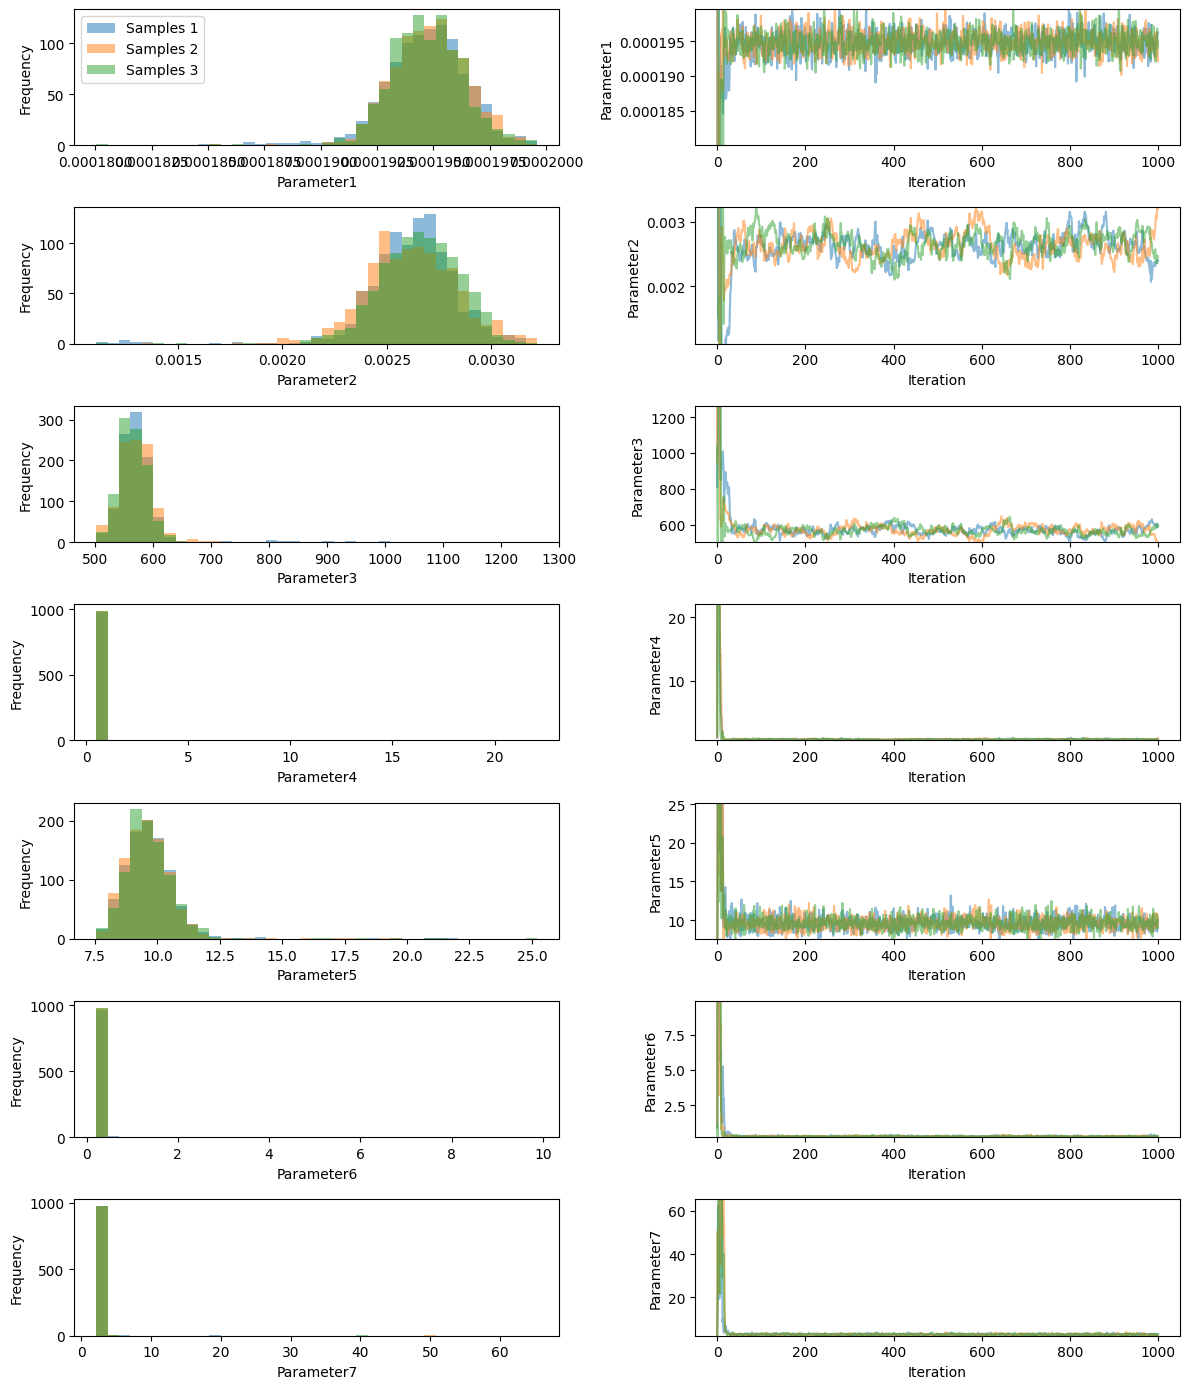

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[1.95861302e-04 2.65096355e-03 5.72015384e+02 6.58019814e-01
 9.48279864e+00 2.72750916e-01 3.04002504e+00]
[[1.95861302e-04 2.65096355e-03 5.72015384e+02 ... 9.48279864e+00
  2.72750916e-01 3.04002504e+00]
 [1.93404878e-04 2.68301216e-03 5.74081699e+02 ... 9.86929614e+00
  2.86228172e-01 2.92821332e+00]
 [1.93051745e-04 2.62656289e-03 5.69777697e+02 ... 9.82459156e+00
  2.94058858e-01 2.69540841e+00]
 ...
 [1.95149184e-04 2.35616695e-03 5.84588645e+02 ... 8.50484239e+00
  3.07263269e-01 2.71592357e+00]
 [1.96207301e-04 2.40878295e-03 6.01213417e+02 ... 1.01243078e+01
  2.73547710e-01 3.07250757e+00]
 [1.96247796e-04 2.39277442e-03 5.99644884e+02 ... 9.65299303e+00
  2.73365105e-01 2.94098506e+00]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


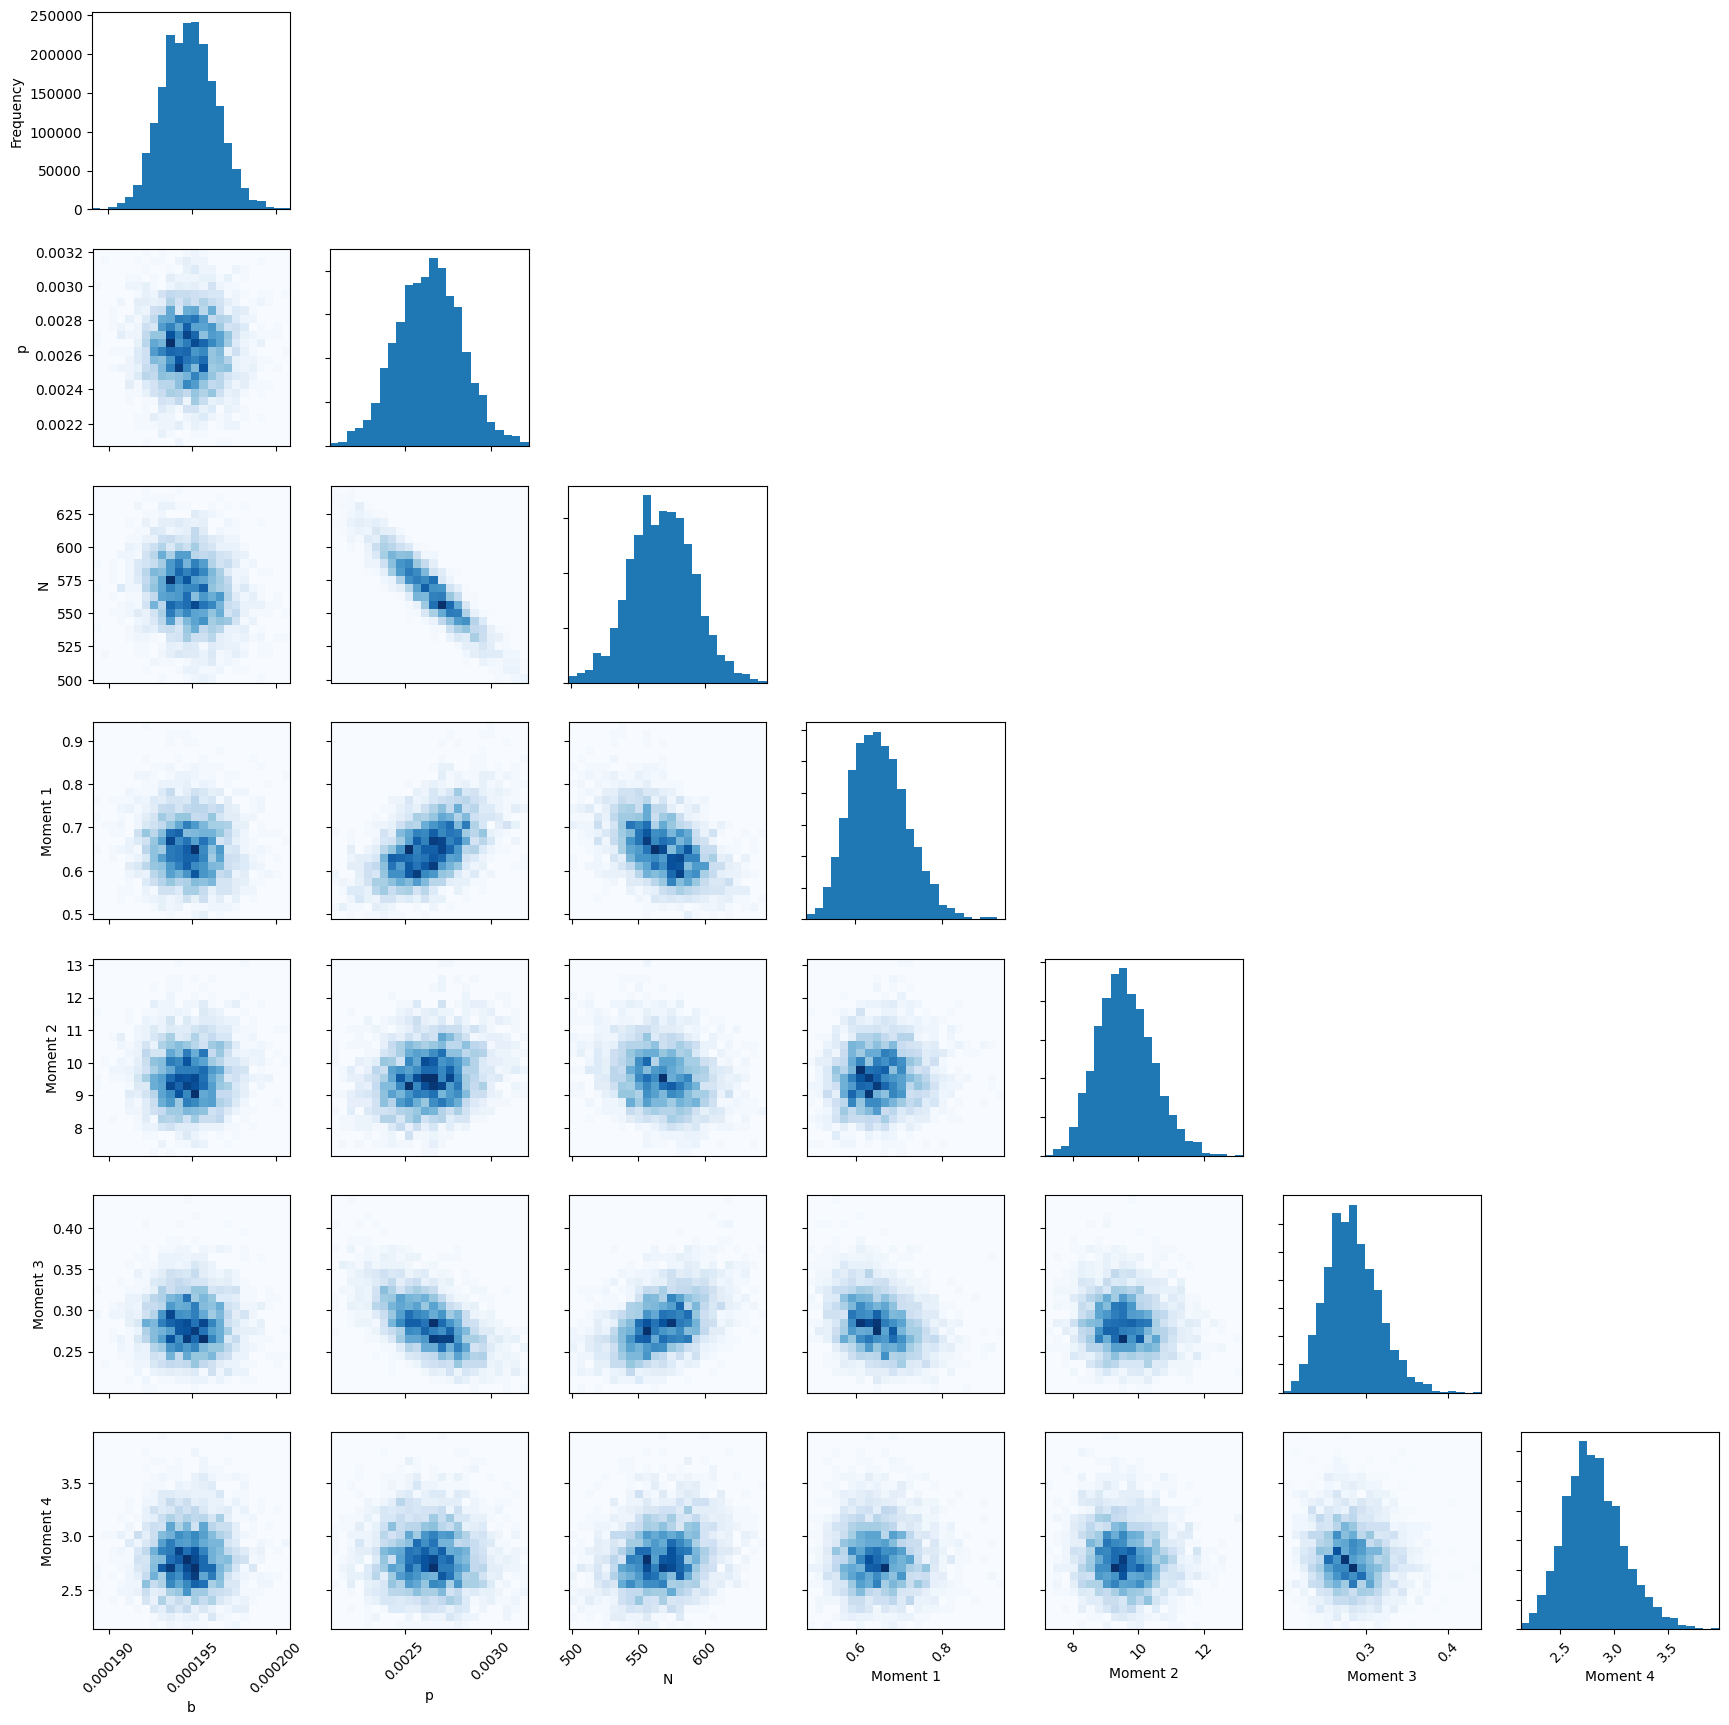

In [10]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

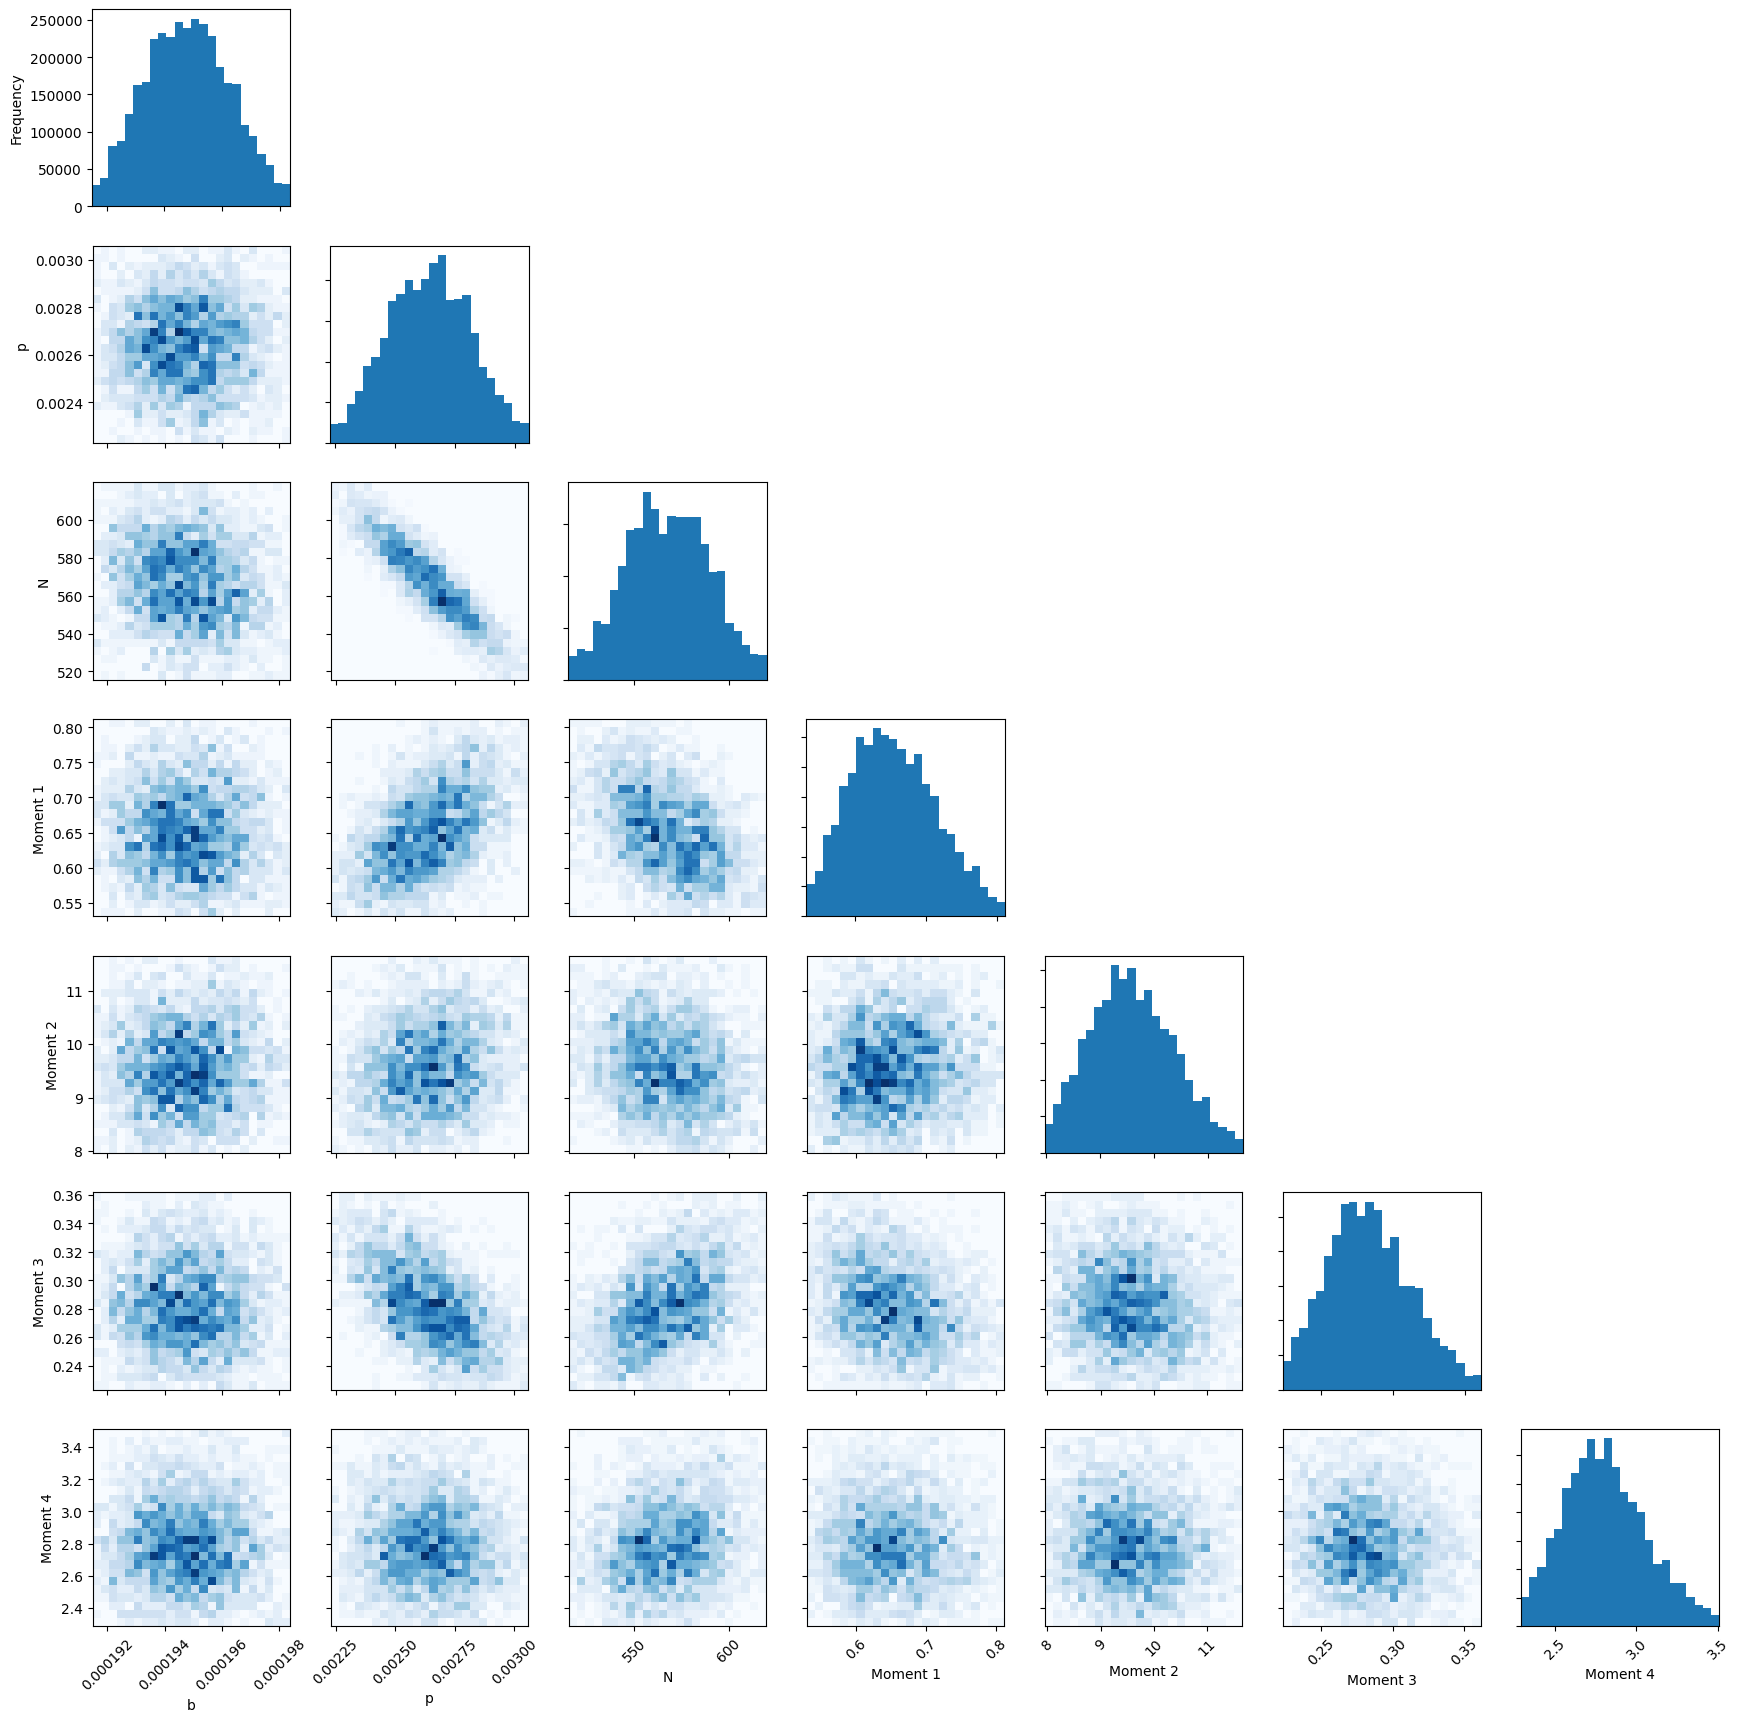

In [11]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

In [12]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    403.83  0.51
p         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.02    72.98   0.09
N         565.92  23.85   517.00  550.13  565.16  582.19  612.22   1.02    68.19   0.09
Moment 1  0.66    0.07    0.54    0.61    0.65    0.70    0.80     1.00    225.51  0.29
Moment 2  9.62    0.86    8.11    9.02    9.55    10.19   11.44    1.00    378.96  0.48
Moment 3  0.28    0.03    0.23    0.26    0.28    0.30    0.35     1.01    196.08  0.25
Moment 4  2.81    0.27    2.34    2.62    2.79    2.97    3.42     1.00    423.60  0.54


In [13]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [14]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000195  1.56e-06  0.000192  0.000194  0.000195  0.000196  0.000198  0.999   404    0.512
p         0.00266   0.000189  0.0023    0.00252   0.00266   0.00278   0.00305   1.02    73     0.0926
N         566       23.8      517       550       565       582       612       1.02    68.2   0.0865
Moment 1  0.658     0.0674    0.543     0.608     0.651     0.701     0.804     1       226    0.286
Moment 2  9.62      0.863     8.11      9.02      9.55      10.2      11.4      0.999   379    0.481
Moment 3  0.283     0.0317    0.228     0.262     0.279     0.303     0.349     1.01    196    0.249
Moment 4  2.81      0.273     2.34      2.62      2.79      2.97      3.42      1       424    0.537


In [15]:
import math
print(math.log(4))
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)


BIC = len(results.mean())*math.log(4) - 2*log_likelihood(results.mean())

print(BIC)

1.3862943611198906
7
1035.4971794629178
1031.201239990757


In [16]:
shape_chains = np.shape(AllChains)

DIC_1 = 0
for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    DIC_1 += -2*log_likelihood(thetas)

DIC_1 = DIC_1/shape_chains[0]

DIC_2 = -2*log_likelihood(results.mean())

DIC = 2*DIC_1 - DIC_2

print(DIC)

1035.2115955430431


In [17]:
import scipy as spy

KS_test_array = []
for i in range(71):
    KS_test = spy.stats.kstest(result_interested[i,:], org_values[i,:])
    KS_test_array = np.append(KS_test_array, KS_test.statistic)

plt.plot(KS_test_array)

NameError: name 'result_interested' is not defined

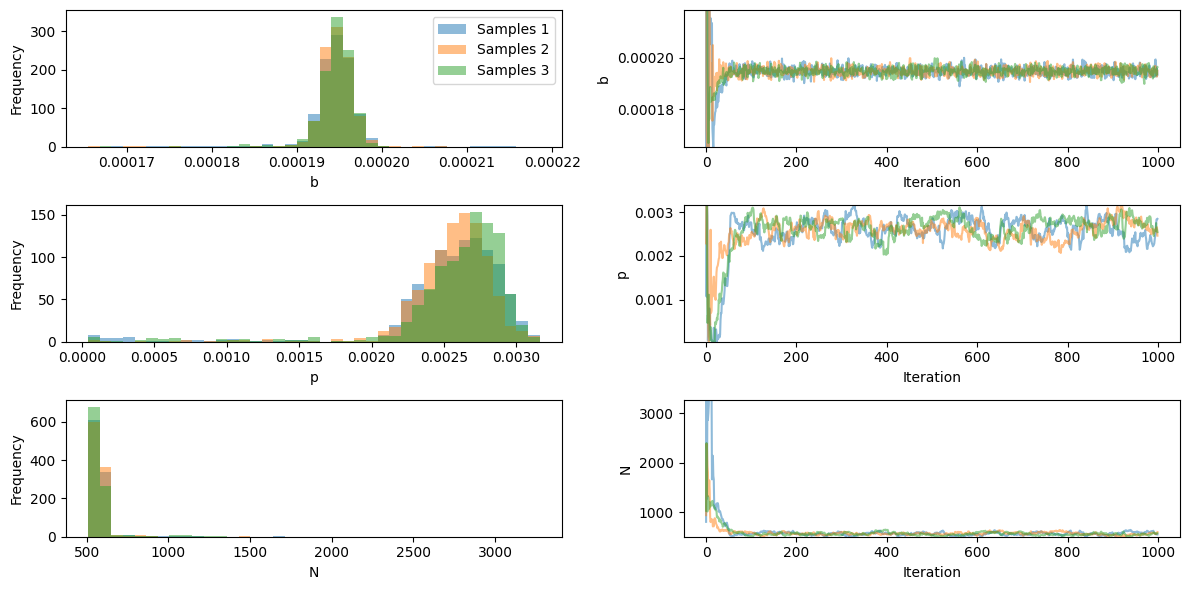

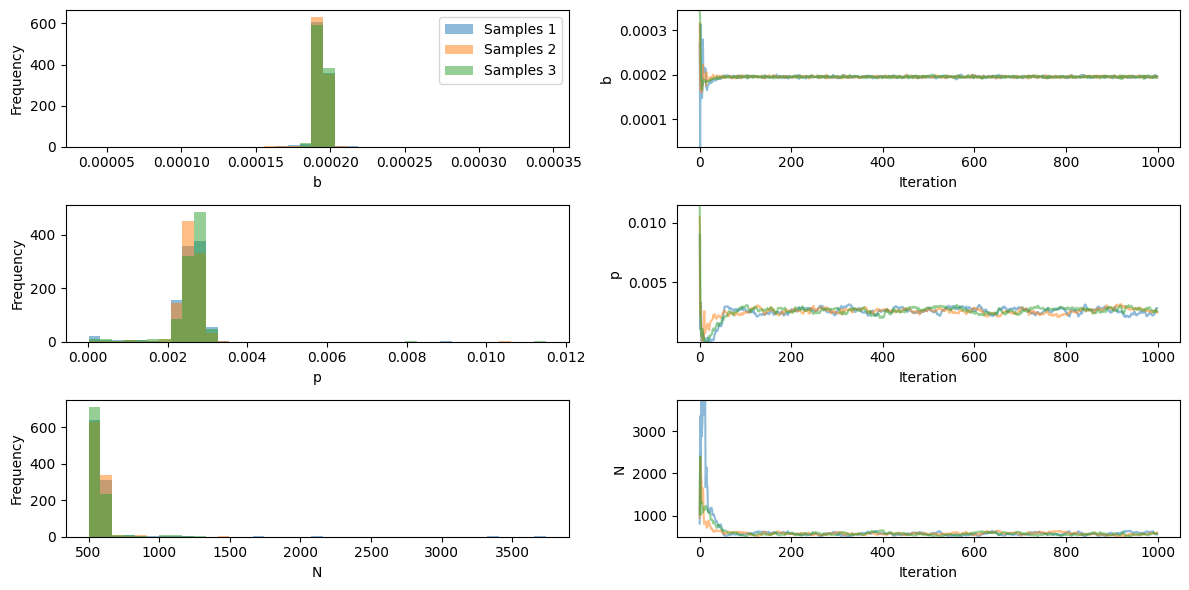

In [ ]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()